In [1]:
import torch
from torch import nn
# from tqdm.auto import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
from torchsummary import summary
torch.manual_seed(0) # Set for testing purposes, please do not change!

In [2]:
# Define a simple CNN model for FashionMNIST with input size 1x28x28
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            self.make_cnn_block(1, 16, 3),
            nn.MaxPool2d(2,2),
            self.make_cnn_block(16, 32, 3),
            self.make_cnn_block(32, 64, 3),
            nn.MaxPool2d(2,2),
            self.make_cnn_block(64, 128, 3,final_layer = True),
        )
        self.fnn = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Linear(128,10)
#             nn.Softmax()
        )
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # self.fc2 = nn.Linear(128, num_classes)

    def make_cnn_block(self, input_channels, output_channels, kernel_size=3, stride=1, padding = 0, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding = padding),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fnn(x)

In [3]:
# Creating the model
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (fnn): Seq

In [4]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         LeakyReLU-3           [-1, 16, 26, 26]               0
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 32, 11, 11]           4,640
       BatchNorm2d-6           [-1, 32, 11, 11]              64
         LeakyReLU-7           [-1, 32, 11, 11]               0
            Conv2d-8             [-1, 64, 9, 9]          18,496
       BatchNorm2d-9             [-1, 64, 9, 9]             128
        LeakyReLU-10             [-1, 64, 9, 9]               0
        MaxPool2d-11             [-1, 64, 4, 4]               0
           Conv2d-12            [-1, 128, 2, 2]          73,856
           Linear-13                  [-1, 256]         131,328
             ReLU-14                  [

/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [5]:
import gzip
import numpy as np

def images(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images

def labels(f):
    with gzip.open(f, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [6]:
training_images = images('train-images-idx3-ubyte.gz')
print(training_images.shape)
training_labels = labels('train-labels-idx1-ubyte.gz')
print(training_labels.shape)
testing_images  = images('t10k-images-idx3-ubyte.gz')
print(testing_images.shape)
testing_labels  = labels('t10k-labels-idx1-ubyte.gz')
print(testing_labels.shape)
print(training_labels)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[9 0 0 ... 3 0 5]


In [7]:
X_train = training_images.reshape(-1,1,28,28)
X_test  = testing_images.reshape(-1,1,28,28)

# Change integers to 32-bit floating point numbers and normalize the datasets
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 1, 28, 28)
Testing matrix shape (10000, 1, 28, 28)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train_torch = torch.tensor(X_train).float()
training_labels_torch = torch.tensor(training_labels).long()
X_test_torch = torch.tensor(X_test).float()
testing_labels_torch = torch.tensor(testing_labels).long()



# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_torch, training_labels_torch, stratify=training_labels, test_size=0.2, random_state=42)

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test_torch,testing_labels_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
for x,y in train_loader:
    print(x.shape,y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/20], Training Loss: 1.7349, Validation Loss: 1.7259, Training Accuracy: 0.7266, Validation Accuracy: 0.7350
Epoch [2/20], Training Loss: 1.7475, Validation Loss: 1.7127, Training Accuracy: 0.7134, Validation Accuracy: 0.7483
Epoch [3/20], Training Loss: 1.7909, Validation Loss: 1.7709, Training Accuracy: 0.6701, Validation Accuracy: 0.6901
Epoch [4/20], Training Loss: 1.7795, Validation Loss: 1.8229, Training Accuracy: 0.6816, Validation Accuracy: 0.6382
Epoch [5/20], Training Loss: 1.7753, Validation Loss: 1.6980, Training Accuracy: 0.6858, Validation Accuracy: 0.7632
Epoch [6/20], Training Loss: 1.7897, Validation Loss: 1.9471, Training Accuracy: 0.6714, Validation Accuracy: 0.5140
Epoch [7/20], Training Loss: 1.8437, Validation Loss: 1.7677, Training Accuracy: 0.6175, Validation Accuracy: 0.6933
Epoch [8/20], Training Loss: 1.7910, Validation Loss: 1.7650, Training Accuracy: 0.6702, Validation Accuracy: 0.6962
Epoch [9/20], Training Loss: 1.7520, Validation Loss: 1.7207, Tr

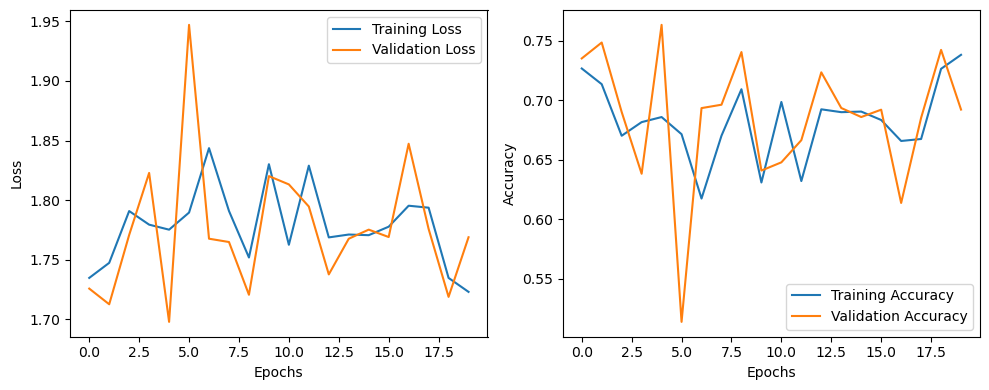

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train_preds += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train_preds / len(train_dataset)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item() * val_inputs.size(0)

            _, predicted = torch.max(val_outputs, 1)
            correct_val_preds += (predicted == val_labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct_val_preds / len(val_dataset)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_cnn_model.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
X_train = training_images.reshape(-1,1,28,28)
X_test  = testing_images.reshape(-1,1,28,28)

# Change integers to 32-bit floating point numbers and normalize the datasets
X_train = X_train.astype('float32')/255

In [13]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


# Load the trained model
 # Initialize your neural network class
model.load_state_dict(torch.load('best_cnn_model.pth'))  # Load the saved best model weights

model.eval()  # Set the model to evaluation mode

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(true_labels, predictions)
print("Classification report for CNN on test dataset :\n%s\n"
      % (metrics.classification_report(true_labels, predictions)))

print("\nConfusion Matrix on Test dataset:")
print(conf_matrix)

Classification report for CNN on test dataset :
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      1000
           1       0.99      0.87      0.93      1000
           2       0.59      0.73      0.65      1000
           3       0.77      0.77      0.77      1000
           4       0.56      0.75      0.64      1000
           5       0.79      0.92      0.85      1000
           6       0.00      0.00      0.00      1000
           7       0.89      0.79      0.84      1000
           8       0.89      0.93      0.91      1000
           9       0.89      0.94      0.91      1000

    accuracy                           0.76     10000
   macro avg       0.70      0.76      0.72     10000
weighted avg       0.70      0.76      0.72     10000



Confusion Matrix on Test dataset:
[[861   0  30  61  17  10   0   1  20   0]
 [ 12 873   1  95  12   4   0   0   3   0]
 [ 56   0 732  11 167  22   0   3   9   0]
 [ 92   0  25 767  96  12   

/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [14]:
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i,data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 500 == 0:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}, {i + 1}] loss: {running_loss / 100}, accuracy: {100 * correct / total}%')
            running_loss = 0.0


print('Finished Training')

/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1, 1] loss: 0.017424002885818482, accuracy: 71.875%
Epoch [1, 501] loss: 8.688861516714097, accuracy: 72.33033932135729%
Epoch [1, 1001] loss: 8.787195260524749, accuracy: 71.35676823176823%
Epoch [2, 1] loss: 0.01711150288581848, accuracy: 75.0%
Epoch [2, 501] loss: 8.597442940473556, accuracy: 74.16417165668663%
Epoch [2, 1001] loss: 8.892146062850951, accuracy: 71.2194055944056%
Epoch [3, 1] loss: 0.017424002885818482, accuracy: 71.875%
Epoch [3, 501] loss: 8.888680378198623, accuracy: 68.33832335329342%
Epoch [3, 1001] loss: 9.30826999783516, accuracy: 64.15147352647352%
Epoch [4, 1] loss: 0.01804900050163269, accuracy: 65.625%
Epoch [4, 501] loss: 9.25709763288498, accuracy: 60.990518962075846%
Epoch [4, 1001] loss: 9.282163034677506, accuracy: 60.72989510489511%
Epoch [5, 1] loss: 0.018361504077911376, accuracy: 62.5%
Epoch [5, 501] loss: 8.95462243437767, accuracy: 67.01596806387225%
Epoch [5, 1001] loss: 9.130197656154632, accuracy: 65.26598401598402%
Epoch [6, 1] loss: 

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train_torch = torch.tensor(X_train).float()
training_labels_torch = torch.tensor(training_labels).long()

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_torch, training_labels_torch, stratify=training_labels, test_size=0.2, random_state=42)

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train_torch.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.softmax(self.fc4(x), dim=1)
        return x

model = SimpleNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train_preds += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train_preds / len(train_dataset)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item() * val_inputs.size(0)

            _, predicted = torch.max(val_outputs, 1)
            correct_val_preds += (predicted == val_labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct_val_preds / len(val_dataset)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_fnn_model.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {epoch_train_loss:.4f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Preparing FashionMNIST data with input size 1x28x28
transform = transforms.Compose([
    transforms.ToTensor(),  # No resizing needed, as FashionMNIST images are already 28x28
])

# Define a function to convert labels to one-hot encoding
def one_hot_encode_labels(labels, num_classes=10):
    return torch.eye(num_classes)[labels]

# Download FashionMNIST dataset
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# # Modify the labels to one-hot encoding for both training and testing sets
# train_data.targets = one_hot_encode_labels(train_data.targets)
# test_data.targets = one_hot_encode_labels(test_data.targets)

# Define data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
print(train_data.targets.shape)
for i in train_loader:
    print(type(i),len(i))
    print(i[0].shape, i[1].shape)
    print(i[1])
    break

In [ ]:
num_epochs = 10
# display_step = 500
# batch_size = 32
lr = 0.01
# momentum=0.9

In [ ]:
# Define optimizer and criterion
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i,data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 500 == 0:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}, {i + 1}] loss: {running_loss / 100}, accuracy: {100 * correct / total}%')
            running_loss = 0.0


print('Finished Training')

In [ ]:
# Set the model to evaluation mode
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
average_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f'Test Loss: {average_test_loss}, Test Accuracy: {test_accuracy}%')


In [ ]:
# # Assuming your input size is 224x224 for VGG16
# # Modify this according to your dataset
# input_size = 224

# for epoch in range(num_epochs):
#     vgg16.train()
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         # Assuming data is in correct format, modify according to your dataset

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward + backward + optimize
#         outputs = vgg16(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 100 == 99:  # Print every 100 mini-batches
#             print(f'Epoch [{epoch + 1}, {i + 1}] loss: {running_loss / 100}')
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
# # Freeze the pre-trained layers
# for param in vgg16.parameters():
#     param.requires_grad = False

# # Replace the classifier with your own fully connected layers
# num_features = vgg16.classifier[6].in_features
# features = list(vgg16.classifier.children())[:-1]  # Remove the last layer
# features.extend([torch.nn.Linear(num_features, 1024)])  # Add your own layers
# features.extend([torch.nn.ReLU(inplace=True)])
# features.extend([torch.nn.Linear(1024, 10)])  # Assuming you have 10 output classes

# vgg16.classifier = torch.nn.Sequential(*features)

# # Assuming your input size is 224x224 for VGG16
# # Modify this according to your dataset
# input_size = 224

# # Define other hyperparameters like learning rate, optimizer, etc.
# # criterion = ...
# # optimizer = ...

# # Example: Define your dataset and data loaders
# # train_loader = ...
# # test_loader = ...

# # Training loop
# num_epochs = 5
# for epoch in range(num_epochs):
#     vgg16.train()
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         # Assuming data is in correct format, modify according to your dataset

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward + backward + optimize
#         outputs = vgg16(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 100 == 99:  # Print every 100 mini-batches
#             print(f'Epoch [{epoch + 1}, {i + 1}] loss: {running_loss / 100}')
#             running_loss = 0.0

# print('Finished Training')ax

# # Evaluate your model
# vgg16.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         outputs = vgg16(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the test images: {100 * correct / total}%')


In [ ]:
# summary(vgg16, (1,56,56))